# About
This notebook shows how Machine Learning helps to **reduce number of ghosts**.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

# Input data

In [2]:
data = pandas.read_csv('hits_1000.csv', index_col=False)
#data = data[data.event.values < 200]

data.head()

,event,particle,layer,iphi,x,y
0,0,0,5,39276,55.103343,-401.233874
1,0,6,5,22685,-381.682239,135.438799
2,0,3,3,6082,160.995866,139.460859
3,0,5,2,27787,-35.433651,-150.895515
4,0,5,1,15230,-19.627350,-82.702885


# Split Data into Train/Test Samples

In [3]:
from sklearn.cross_validation import train_test_split

event_ids = numpy.unique(data.event.values)

event_ids_train, event_ids_test = train_test_split(event_ids, 
                                                   test_size=0.5, 
                                                   random_state=42)

data_train = data[data.event.isin(event_ids_train)]
data_test = data[data.event.isin(event_ids_test)]

# Tracks Classification

## Track Recognition for Train Sample

The recognized tracks will be used to train a tracks classifier.

In [4]:
from hough import Hough
from recognizer import TrackRecognizer
from metrics import RecognitionQuality


h = Hough(n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=4)

tr = TrackRecognizer(method=h)
reco_results = tr.predict(data_train)

rq = RecognitionQuality(data_train, reco_results, track_eff_threshold=0.8, min_hits_per_track=4)
report_event, report_tracks = rq.calculate()

## Track Features Generation

The following function calculate track features which will be used to tracin the classifier.

In [5]:
from regression import TrackRegression

def track_features(x, y):
    
    n_hits = len(x)
    
    tr = TrackRegression()
    tr.fit(x, y)

    theta, invr = tr.theta_, tr.invr_
    
    phi = numpy.arctan(y / x) * (x != 0) + numpy.pi * (x < 0) + 0.5 * numpy.pi * (x==0) * (y>0) + 1.5 * numpy.pi * (x==0) * (y<0)
    r = numpy.sqrt(x**2 + y**2)
    
    x_pred, y_pred = tr.predict(phi)
    
    rmse = numpy.sqrt(((y - y_pred)**2).sum())
    
    return n_hits, theta, invr, rmse

Calculation the track feature values for the all recognized tracks in the train sample events.

In [6]:
XX = []
labels = []

for event_id in numpy.unique(reco_results.event.values):
    
    event = reco_results[reco_results.event.values == event_id]
    
    for track_id in numpy.unique(event.track.values[event.track.values != -1]):
        
        track = event[event.track.values == track_id]
        
        features = track_features(track.x.values, track.y.values)
        
        XX.append(features)
        
        track_eff = report_tracks[(report_tracks.Event.values == event_id)*(report_tracks.Track.values == track_id)]
        label = (track_eff.TrackEfficiency.values[0] >= 0.8) * 1.
        
        labels += [label]
        
XX = numpy.array(XX)
labels = numpy.array(labels)

## Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(XX, 
                                                    labels, 
                                                    test_size=0.5, 
                                                    random_state=42)

## Sample Weights

In [8]:
weights = numpy.zeros(len(y_train))
weights += 1. * len(y_train) / len(y_train[y_train == 0]) * (y_train == 0) + \
           1. * len(y_train) / len(y_train[y_train == 1]) * (y_train == 1)

## Classification

Train the classifier to separate good and ghost tracks.

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train, sample_weight=weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
y_proba_test = clf.predict_proba(X_test)[:, 1]

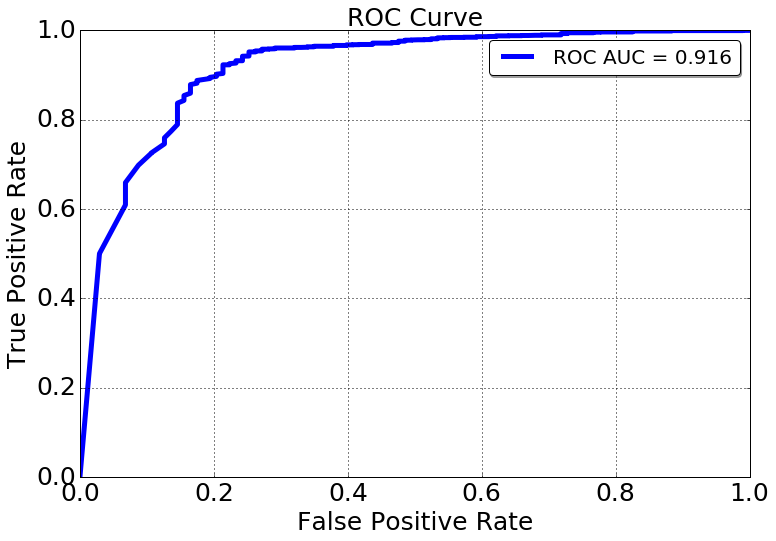

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(12, 8))

fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

plt.plot(fpr, tpr, label='ROC AUC = %.3f' %roc_auc, color='b', linewidth=5)

plt.legend(loc="best", prop={'size':20},  shadow=True, fancybox=True)

plt.title("ROC Curve", fontsize=25)
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(linewidth=1)
plt.show()

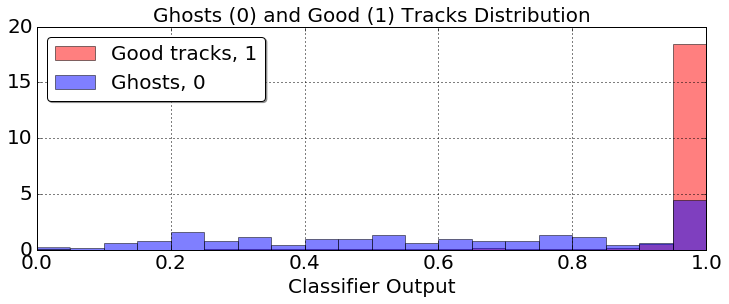

In [12]:
plt.figure(figsize=(12, 4))
plt.hist(y_proba_test[y_test==1], bins=numpy.linspace(0, 1, 21), alpha=0.5, color='r', label='Good tracks, 1', normed=True)
plt.hist(y_proba_test[y_test==0], bins=numpy.linspace(0, 1, 21), alpha=0.5, color='b', label='Ghosts, 0', normed=True)
plt.legend(loc="best", prop={'size':20},  shadow=True, fancybox=True)

plt.title("Ghosts (0) and Good (1) Tracks Distribution", fontsize=20)
plt.xlabel('Classifier Output', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linewidth=1)
plt.show()

# Hough Transform Modification

Modify the Hough Transform method to be able to use the trained classifier.

In [13]:
class Method(object):
    
    def __init__(self, params):
        
        # You code
        
        pass
    
    def fit(X, y):
        """
        Parameters
        ----------
        X : ndarray-like:
            Coordinates of hits (x, y).
        y : array-like
            True hit labels.
        """
        
        # Your code
        
        pass
    
    def predict(self, X):
        """
        Parameters
        ----------
        X : ndarray-like:
            Coordinates of hits (x, y).
            
        Returns
        -------
        y : array-like
            True hit labels.
        """
        
        # Your code
        
        return y

In [18]:
from hough import Hough
from regression import TrackRegression

class ModifiedHough(Hough):
    
    def __init__(self, n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=4, classifier=None, proba_threshold=0.8):
        
        self.classifier = classifier
        self.proba_threshold = proba_threshold
        
        Hough.__init__(self, n_theta_bins, n_radius_bins, min_radius, min_hits)
    
    def new_track_inds(self, track_inds, X, classifier):
        
        x, y = X[:, 0], X[:, 1]
        
        if classifier == None:
            return track_inds

        XX = []
        
        for track in track_inds:
            
            features = track_features(x[track], y[track])
            XX.append(features)
            
        XX = numpy.array(XX)
        
        labels_pred = classifier.predict_proba(XX)[:, 1]
        
        track_inds = numpy.array(track_inds)
        new_track_inds = track_inds[labels_pred >= self.proba_threshold] # Larger the threshold value, better the ghosts reduction

        return new_track_inds

    
    def predict(self, X):
        
        Hough.predict(self, X)
        
        self.track_inds_ = self.new_track_inds(self.track_inds_, X, self.classifier)
        labels = self.get_hit_labels(self.track_inds_, len(X))
        
        return labels

## Test Events

In [19]:
from recognizer import TrackRecognizer

method = ModifiedHough(n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=4, classifier=clf, proba_threshold=0.8)

tr = TrackRecognizer(method=method)
results = tr.predict(data_test)

results.head()

,event,track,x,y
0,0,2,55.103343,-401.233874
1,0,3,-381.682239,135.438799
2,0,5,160.995866,139.460859
3,0,0,-35.433651,-150.895515
4,0,-1,-19.627350,-82.702885


## Quality metrics

In [20]:
from metrics import RecognitionQuality

rq = RecognitionQuality(data_test, results, track_eff_threshold=0.8, min_hits_per_track=4)
report_event, report_tracks = rq.calculate()

In [21]:
report_event.mean(axis=0)

Event                       484.638000
ReconstructionEfficiency      0.929323
GhostRate                     0.030119
CloneRate                     0.000000
AvgTrackEfficiency            0.979953
dtype: float64